# Trajectory optimization to Lagrange points

JWST/Drake resources: https://webbtelescope.org/contents/media/images/01F4STZH25YJH07WTN7XJYQP8P#:~:text=This%20%22halo%20orbit%22%20around%20L2,from%20Earth%20varies%20over%20time.

https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-orbit

https://webb.nasa.gov/content/about/orbit.html

https://ntrs.nasa.gov/api/citations/20140008868/downloads/20140008868.pdf

https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb

https://github.com/RobotLocomotion/drake/blob/master/tutorials/debug_mathematical_program.ipynb

https://diposit.ub.edu/dspace/bitstream/2445/181696/2/tfg_pablo_romero_marimon.pdf

https://farside.ph.utexas.edu/teaching/336k/Newton/node126.html

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
from matplotlib import rcParams
from pydrake.all import MathematicalProgram, PiecewisePolynomial, SnoptSolver
from matplotlib.animation import FuncAnimation

# increase default size matplotlib figures
plt.rc("text", usetex=False)
plt.rc("font", family="Arial") 
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
font = {"weight": "normal", "size": 8}
plt.rc(font)

In [2]:
# dictionary of functions to convert the units of the problem data
# the fist argument is the numeric value we want to convert
# the second argument is the unit power
# e.g., m = 2 and power = 2 for square meters
unit_converter = {
    "mass": lambda m, power=1: m / 1e3**power,  # takes kilos, returns tons
    "length": lambda l, power=1: l
    / 1e11**power,  # takes meters, returns hundreds of gigameters
    "time": lambda t, power=1: t
    / (60 * 60 * 24 * 30 * 12) ** power,  # takes seconds, returns years
}
sun_mass = unit_converter["mass"](1.989e30)

## JWST Model

In [3]:
# simple class to store the rocket data
class Satellite(object):
    def __init__(
        self,
        mass,  # mass of the satellite in kg
        thrust_limit,  # max norm of the thrust in kg * m * s^-2
        velocity_limit,  # max norm of the velocity in m * s^-1
    ):
        # store mass using the scaled units
        self.mass = unit_converter["mass"](mass)

        # store thrust limit converting the units one by one
        thrust_units = [("mass", 1), ("length", 1), ("time", -2)]
        for quantity, power in thrust_units:
            thrust_limit = unit_converter[quantity](thrust_limit, power)
        self.thrust_limit = thrust_limit

        # store velocity limit converting the units one by one
        velocity_units = [("length", 1), ("time", -1)]
        for quantity, power in velocity_units:
            velocity_limit = unit_converter[quantity](velocity_limit, power)
        self.velocity_limit = velocity_limit


# instantiate
satellite = Satellite(
    6500, # mass of JWST in kg
    1,  # very small thrust limit in kg * m * s^-2
    2500, # very small velocity limit in m * s^-1
)

`Planet` class for defining planets, Sun, and Lagrange points.

In [4]:
ME, MS = 5.97e24, 1.989e30 # masses of Earth and Sun
mu = ME/(ME+MS)

class Planet(object):
    def __init__(
        self,
        name,  # string with the name of the planet
        color,  # color of the planet for plots
        mass,  # mass of the planet in kg
        position,  # position of the planet in the 2d universe in m
        eccentricity,
        orbit,  # radius of the orbit in m
        orbit_eccentricity,
        radius=np.nan,  # radius of the planet in m (optional)
    ):
        # store the data using the scaled units
        self.name = name
        self.mass = unit_converter["mass"](mass)
        self.position = unit_converter["length"](position)
        self.eccentricity = eccentricity
        self.radius = unit_converter["length"](radius)
        self.orbit = unit_converter["length"](orbit)
        self.orbit_eccentricity = orbit_eccentricity
        self.color = color

sun = Planet(
    "Sun",  # name of the planet
    "yellow",  # color for plot
    1.989e30,  # mass in kg
    np.array([0, 0]),  # Sun is chosen as the origin of our 2D universe,
    0,
    0,  # orbit radius in m,
    0,
    3e7,  # radius in m
)

# planet Earth: https://en.wikipedia.org/wiki/Earth
earth = Planet(
    "Earth",  # name of the planet
    "green",  # color for plot
    5.972e24,  # mass in kg
    np.array([1.496e11, 0]),  # (average) distance wrt Sun in m,
    0,
    1e7,  # 1.3e9, orbit radius in m (chosen "big enough" for the plots),
    0,
    6.378e6,  # planet radius in m
)

# planet Mars: https://en.wikipedia.org/wiki/Mars
mars = Planet(
    "Mars",  # name of the planet
    "red",  # color for plot
    6.417e23,  # mass in kg
    np.array([1.5*1.496e11, 0]),
    0,
    1.5e10,  # orbit radius in m
    0,
    3.389e6,  # radius in m
)

earth_sun_l1 = Planet(
    "Earth-Sun L1",  # name of the planet
    "blue",  # color for plot
    0,  # mass in kg
    np.array([1.496e11-1.5e9, 0]),  # (average) distance wrt Sun in m,
    0,
    500e6,  # orbit radius in m (chosen "big enough" for the plots)
    0.,
    6.378e5,  # planet radius in m
)

earth_sun_l2 = Planet(
    "Earth-Sun L2",  # name of the planet
    "blue",  # color for plot
    0,  # mass in kg
    np.array([1.496e11+1.5e9, 0]),  # (average) distance wrt Sun in m,
    0,
    500e6,  # orbit radius in m (chosen "big enough" for the plots)
    0.,
    6.378e5,  # planet radius in m
)

earth_sun_l3 = Planet(
    "Earth-Sun L3",  # name of the planet
    "blue",  # color for plot
    0,  # mass in kg
    np.array([-1.496e11 * (1-7/12*mu), 0]),  # (average) distance wrt Sun in m,
    0,
    500e6,  # orbit radius in m (chosen "big enough" for the plots)
    0.,
    6.378e5,  # planet radius in m
)

earth_sun_l4 = Planet(
    "Earth-Sun L4",  # name of the planet
    "blue",  # color for plot
    0,  # mass in kg
    1.496e11 * np.array([1/2, np.sqrt(3)/2]),  # (average) distance wrt Sun in m,
    0,
    500e6,  # orbit radius in m (chosen "big enough" for the plots)
    0.,
    6.378e5,  # planet radius in m
)
earth_sun_l5 = Planet(
    "Earth-Sun L5",  # name of the planet
    "blue",  # color for plot
    0,  # mass in kg
    1.496e11 * np.array([1/2, -np.sqrt(3)/2]),  # (average) distance wrt Sun in m,
    0,
    500e6,  # orbit radius in m (chosen "big enough" for the plots)
    0.,
    6.378e5,  # planet radius in m
)

# asteroids with random data in random positions
np.random.seed(0)
n_asteroids = 10
asteroids = []
for i in range(n_asteroids):
    mass = np.abs(np.random.randn()) * 5e22
    orbit = mass / 5e12
    earth_from_mars = unit_converter["length"](earth.position, -1)
    asteroid_from_mars = np.random.randn(2) * 3e10 + earth_from_mars / 2
    asteroids.append(
        Planet(
            f"Asteroid_{i}",  # name of the planet
            "brown",  # color for plot
            mass,  # mass in kg
            asteroid_from_mars,  # distance from Mars in m
            0,
            mass / 5e12,  # radius danger area in m,
            0
        )
    )

In [5]:
# main class of the notebook
# it collects jwst, the planets, and lagrange points
# implements utility functions needed to write the trajopt

class Universe(object):
    def __init__(
        self,
        rocket,
        planets,  # instance of Rocket  # list of instances of Planet
    ):
        # store data
        self.rocket = rocket
        self.planets = planets

        # gravitational constant in m^3 * kg^-1 * s^-2
        self.G = 6.67e-11

        # gravitational constant in the scaled units
        G_units = [("length", 3), ("mass", -1), ("time", -2)]
        for quantity, power in G_units:
            self.G = unit_converter[quantity](self.G, power)
        self.omega_E = np.sqrt(self.G*unit_converter["mass"](1.99e30) / (unit_converter["length"](1.496e11))**3)

    def free_evolution_forward_step(self, state, dt):
        return state + self.rocket_continuous_dynamics(state, np.array([0,0])) * dt

    def planet_orbit_rel_pos(self, name, t):
        planet = self.get_planet(name)
        a = (planet.position.dot(planet.position))**0.5
        omega = self.G * self.get_planet("Sun").mass / a**3
        return a * np.array([np.cos(omega*t), np.sin(omega*t)]) 
    
    def planet_orbit_rel_vel(self, name, t):
        planet = self.get_planet(name)
        a = (planet.position.dot(planet.position))**0.5
        omega = self.G * self.get_planet("Sun").mass / a**3
        return a * omega * np.array([-np.sin(omega*t), np.cos(omega*t)]) 

    # given the planet name, returns the Planet instance
    def get_planet(self, name):
        # loop through the planets in the universe
        for planet in self.planets:
            if planet.name == name:
                return planet

        # in case no planet has the given name
        print(name + " is not in the Universe!")

    # computes  2D distance vector between the rocket and a planet,
    # given the rocket state and the planet name
    def position_wrt_planet(self, state, name):
        # rocket position wrt to the planet position
        planet = self.get_planet(name)
        p = state[:2] - planet.position

        return p

    # computes the rocket acceleration due to a planet
    def acceleration_from_planet(self, state, name):
        # distance from the planet
        p = self.position_wrt_planet(state, name)
        d = p.dot(p) ** 0.5

        # 2d acceleration vector
        planet = self.get_planet(name)
        a = -self.G * planet.mass / d**3 * p

        return a

    # right-hand side of the rocket continuous-time dynamics
    # in the form state_dot = f(state, thrust)
    # (thrust is a 2D vector with the horizontal and vertical thrusts)
    def rocket_continuous_dynamics(self, state, thrust):
        # thrust acceleration
        a = thrust / self.rocket.mass

        # accelerations due to the planets
        for planet in self.planets:
            a = a + self.acceleration_from_planet(state, planet.name)
        a = a + self.omega_E**2 * state[:2] - 2*self.omega_E*np.cross(np.array([0,0,1]), state[2:])[:2]
        # concatenate velocity and acceleration
        state_dot = np.concatenate((state[2:], a))

        return state_dot

    # residuals of the rocket discrete-time dynamics
    # if the vector of residuals is zero, then this method's
    # arguments verify the discrete-time dynamics
    # (implements the implicit Euler integration scheme:
    # https://en.wikipedia.org/wiki/Backward_Euler_method)
    def rocket_discrete_dynamics(self, state, state_next, thrust, time_step):
        # continuous-time dynamics evaluated at the next time step
        state_dot = self.rocket_continuous_dynamics(state_next, thrust)

        # implicit-Euler state update
        residuals = state_next - state - time_step * state_dot

        return residuals

    # helper function for the trajopt problem
    # if the vector of residuals is zero, then the state of
    # the rocket belongs to the desired orbit of the given planet
    # (i.e.: the rocket is on the given orbit, with zero radial
    # velocity, and zero radial acceleration)
    def constraint_state_to_orbit(self, state, thrust, planet_name, fixed_orbit=True):
        # unpack state, rocket position in relative coordinates
        planet = self.get_planet(planet_name)
        p = state[:2] - planet.position
        v = state[2:]

        # constraint on radial distance
        # sets x^2 + y^2 to the orbit radius squared
        residual_p = p.dot(p) - planet.orbit**2

        # radial velocity must be zero
        # sets the time derivative of x^2 + y^2 to zero
        residual_v = p.dot(v)

        # radial acceleration must be zero with zero input
        # sets the second time derivative of x^2 + y^2 to zero
        # why this extra constraint?
        # knowing that the radial velocity is zero is not enough
        # the tangential velocity must be such that the gravitational
        # force is balanced by the centrifugal force
        a = thrust / self.rocket.mass
        for planet in self.planets:
            a = a + self.acceleration_from_planet(state, planet.name)
        residual_a = p.dot(a) + v.dot(v)

        # gather constraint residuals
        residuals = np.array([residual_p, residual_v, residual_a]) if fixed_orbit else np.array([residual_v, residual_a])

        return residuals


# instantiate universe
planets = [earth, sun, earth_sun_l2] #+ asteroids
#planets += [earth_sun_l4, earth_sun_l3, earth_sun_l5]
universe = Universe(satellite, planets)

## Plot Functions

In [6]:
# helper function that plots a circle centered at
# the given point and with the given radius


def plot_circle(fig, ax, center, radius, *args, **kwargs):
    # discretize angle
    angle = np.linspace(0, 2 * np.pi)

    # plot circle
    ax.plot(
        center[0] + radius * np.cos(angle),
        center[1] + radius * np.sin(angle),
        *args,
        **kwargs
    )


# function that draws the state-space trajectory of the rocket
# including the planets and the asteroids
def plot_state_trajectory(trajectory, universe, fig=None, ax=None):
    if fig is None:
        fig = plt.figure()
        ax = plt.axes()
    for planet in universe.planets:
        if planet != sun: # won't include sun in plots in order to zoom in on Earth-L2 trajectory
            # plot planets
            ax.scatter(*planet.position, s=100, c=planet.color)
            ax.text(*planet.position, planet.name)

            # plot orbits
            if not np.isnan(planet.orbit):
                if planet.name == "Asteroid_1":
                    orbit_label = "Asteroid danger area"
                elif planet.name[:8] == "Asteroid":
                    orbit_label = None
                else:
                    orbit_label = planet.name + " orbit"
                plot_circle(
                    fig,
                    ax,
                    planet.position,
                    planet.orbit,
                    label=orbit_label,
                    color=planet.color,
                    linestyle="--",
                )

    # plot rocket trajectory
    if trajectory is not None:
        pass
        ax.plot(trajectory.T[0], trajectory.T[1], color="k", label="Satellite trajectory")
        ax.scatter(trajectory[0, 0], trajectory[0, 1], color="k")
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], color="k")

    # misc settings
    length_unit = unit_converter["length"](1)
    ax.set_xlabel("{:.0e} meters".format(1/length_unit))
    ax.set_ylabel("{:.0e} meters".format(1/length_unit))
    ax.grid(True)
    ax.set_aspect("equal")

    # legend
    n_legend = len(ax.get_legend_handles_labels()[0])
    #ax.legend(
     #   loc="upper center",
      #  ncol=int(n_legend / 2),
       # bbox_to_anchor=(0.5, 1.25),
        #fancybox=True,
        #shadow=True,
    #)
    return fig, ax


# function that plots the norm of the rocket thrust and
# velocity normalized on their maximum value
def plot_rocket_limits(rocket, thrust, state):
    # reconstruct time vector
    time_steps = thrust.shape[0]
    time = np.linspace(0, time_steps, time_steps + 1)

    # plot maximum norm limit
    plt.plot(time, np.ones(time_steps + 1), "r--", label="Limit")

    # plot normalized thrust
    thrust_norm = [np.linalg.norm(t) / np.max(thrust) for t in thrust] # rocket.thrust_limit
    plt.step(time, [thrust_norm[0]] + thrust_norm, label="Thrust / thrust limit")

    # plot normalized velocity
    velocity_norm = [np.linalg.norm(v) / rocket.velocity_limit for v in state[:, 2:]]
    plt.plot(time, velocity_norm, label="Velocity / velocity limit")

    # plot limits
    plt.xlim(0, time_steps)
    ymax = max(1, max(thrust_norm), max(velocity_norm)) * 1.05
    plt.ylim(0, ymax)

    # misc settings
    plt.xlabel("Time step")
    plt.grid(True)
    plt.legend()

## Trajectory Optimization

In [7]:
# function that interpolates two given positions of the rocket
# velocity is set to zero for all the times

def interpolate_rocket_state(p_initial, p_final, time_steps):
    np.random.seed(0)

    # initial and final time and state
    time_limits = [0.0, time_steps * time_interval]
    position_limits = np.column_stack((p_initial, p_final))
    state_limits = np.vstack((position_limits, np.zeros((2, 2))))

    # linear interpolation in state
    state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)

    # sample state on the time grid and add small random noise
    state_guess = np.vstack(
        [state.value(t * time_interval).T for t in range(time_steps + 1)]
    )
    state_guess += np.random.rand(*state_guess.shape) * 1e-3

    return state_guess

In [8]:
# numeric parameters

time_range = 200/365
transfer_time = 30/365
burn_time = 21/365
time_steps = 200
time_interval = 1/(365) #time_range / time_steps  # in years
num_steps_transfer = int(transfer_time / time_interval)
num_steps_each_burn = int(burn_time / time_interval)
print("steps to transfer", num_steps_transfer)
print(f"station keeping every {num_steps_each_burn} steps")

halo_radius = universe.get_planet("Earth-Sun L2").orbit
halo_period = 0.5
halo_vel = 2*np.pi*halo_radius / halo_period

cumulative_delta_v = unit_converter["length"](100) / unit_converter["time"](1) #66.5
max_thrust = cumulative_delta_v * satellite.mass / time_interval

def circle_traj(init_state, vector_offset = np.array([0,0]), R = halo_radius, num_knots = 100):
    """
    initial guess for halo orbit optimization. creates num_knots number of points around a circle of radius R
    starting with init_state
    vector_offset to transform to heliocentric coordinate system
    """
    theta = np.arctan2(init_state[1], init_state[0])
    omega = np.sqrt(init_state[2]**2 + init_state[3]**2) / R
    phases = np.linspace(0,2*np.pi,num_knots)
    out = []
    for phase in phases:
        to_append = np.array([vector_offset[0] + R*np.cos(-phase + theta), vector_offset[1] + R*np.sin(-phase + theta), R*omega*np.cos(-phase + theta), -R*omega*np.sin(-phase + theta)])
        out.append(to_append)
    return out

def fuel_consumption(thrust, time_interval):
    return time_interval * sum(t.dot(t) for t in thrust)

def jwst_dirtrans(initial_state=None, halo_orbit=False, time_steps=200, lagrange_pt = "Earth-Sun L2"):
    """
    implements direct transcription for JWST
    """
    for prop in [1.5]: # 24
        # initialize optimization
        prog = MathematicalProgram()

        # optimization variables
        state = prog.NewContinuousVariables(time_steps + 1, 4, "state")
        thrust = prog.NewContinuousVariables(time_steps, 2, "thrust")

        # initial orbit constraints
        if not halo_orbit:
            for residual in universe.constraint_state_to_orbit(state[0], thrust[0], "Earth"):
                prog.AddConstraint(residual == 0)
            #prog.AddConstraint(state[0][0] == universe.get_planet("Earth").position[0])
            #prog.AddConstraint(state[0][1] == universe.get_planet("Earth").position[1] - unit_converter["length"](1e7)) 
            #prog.AddConstraint(state[0][2] == unit_converter["length"](0) / unit_converter["time"](1))
            #prog.AddConstraint(state[0][3] == unit_converter["length"](10e3) / unit_converter["time"](1))
            #prog.AddConstraint(thrust[0][0] == 0)
            #prog.AddConstraint(thrust[0][1] == 0)
        else:
            prog.AddConstraint(state[0][0] == initial_state[0])
            prog.AddConstraint(state[0][1] == initial_state[1])
            prog.AddConstraint(state[0][2] == initial_state[2])
            prog.AddConstraint(state[0][3] == initial_state[3])

        # terminal orbit constraints
        if not halo_orbit:
            for t in range(time_steps):
                if (t == num_steps_transfer - 1): #or (t % num_steps_each_burn == ((num_steps_transfer + 1) % num_steps_each_burn) and t > num_steps_transfer):
                    for residual in universe.constraint_state_to_orbit(state[t], thrust[t], lagrange_pt, fixed_orbit=True):
                        prog.AddConstraint(residual == 0)
                    prog.AddConstraint(state[t][2]**2 + state[t][3]**2 == halo_vel**2)  
        else:
            prog.AddConstraint(state[-1][0] == initial_state[0])
            prog.AddConstraint(state[-1][1] == initial_state[1])
            prog.AddConstraint(state[-1][2] == initial_state[2])
            prog.AddConstraint(state[-1][3] == initial_state[3])

        # discretized dynamics
        for t in range(time_steps):
            residuals = universe.rocket_discrete_dynamics(
                state[t], state[t + 1], thrust[t], time_interval
            )
            for residual in residuals:
                prog.AddConstraint(residual == 0)

        # initial guess
        if not halo_orbit:
            state_guess = interpolate_rocket_state(
                np.array([universe.get_planet("Earth").position[0] + universe.get_planet("Earth").orbit, universe.get_planet("Earth").position[1]]),
                universe.get_planet("Earth-Sun L2").position,
                time_steps,
            )
        else:
            state_guess = np.array(circle_traj(initial_state, halo_radius, time_steps+1))
        prog.SetInitialGuess(state, state_guess)

        # thrust constraint
        for t in range(time_steps):
            if (t > num_steps_transfer and t % num_steps_each_burn != num_steps_transfer % num_steps_each_burn): 
                prog.AddConstraint(
                        thrust[t][0]**2 + thrust[t][1]**2 == 0.)

        # proximity constraint
        for t in range(time_steps):
            if t >= num_steps_transfer - 1:
                prog.AddConstraint(
                    lambda z: np.array([((z[0] - universe.get_planet("Earth-Sun L2").position[0])**2 + (z[1] - universe.get_planet("Earth-Sun L2").position[1])**2)]),
                    lb=[0.],
                    ub=[prop*universe.get_planet("Earth-Sun L2").orbit**2],
                    vars=state[t][:2])

        # cost
        for t in range(time_steps):
            prog.AddCost(lambda z: time_interval * (z[0]**2 + z[1]**2), vars = thrust[t])

        # solve mathematical program
        solver = SnoptSolver()
        result = solver.Solve(prog)

        # be sure that the solution is optimal
        print("solve success ", result.is_success())

        # retrieve optimal solution
        thrust_opt = result.GetSolution(thrust) if result.is_success() else thrust
        state_opt = result.GetSolution(state) if result.is_success() else state_guess

        # compute fuel consumption for the optimal trajectory
        
        #print(
         #   f"Is fuel consumption {fuel_consumption(thrust_opt, time_interval)} lower than {satellite.mass * cumulative_delta_v}?"
        #)
        return thrust_opt, state_opt
thrust_opt, state_opt = jwst_dirtrans(time_steps=30)

# uncomment below to run separate optimizations for halo orbit using last sate from previous trajectory
# as initial state of current trajectory

#thrust_opt2, state_opt2 = jwst_dirtrans(state_opt1[-1], halo_orbit=True, time_steps=200)
#thrust_opt3, state_opt3 = jwst_dirtrans(state_opt2[-1], halo_orbit=True, time_steps=200)
#state_opt = np.concatenate([state_opt1, state_opt2, state_opt3])
#thrust_opt = np.concatenate([thrust_opt1, thrust_opt2, thrust_opt3])

steps to transfer 29
station keeping every 21 steps
solve success  True


## Plot the Optimization Results

In [9]:
free_steps = int(50/365/time_interval)
def append_free_evoln(state_opt, free_steps):
    """
    to visualize drift of open loop system after turning off thrusters
    """
    out = []
    current_state = state_opt[-1]
    for t in range(free_steps):
        if t % num_steps_each_burn == 0:
            #temp_pos = current_state[:2] - universe.get_planet(lagrange_pt).position
            #x, y = temp_pos[0], temp_pos[1]
            #temp_radius = np.sqrt(temp_pos.dot(temp_pos))
            #tangential_vel = 2*np.pi*temp_radius / halo_period * np.array([y, -x]) / temp_radius
            #burn = (tangential_vel - current_state[2:]) / time_interval - universe.rocket_continuous_dynamics(current_state, np.array([0,0]))[2:]
            #new_state = np.concatenate([current_state[:2] + time_interval*current_state[2:], tangential_vel])
            new_state = universe.free_evolution_forward_step(current_state, time_interval)
        else:
            new_state = universe.free_evolution_forward_step(current_state, time_interval)
        out.append(new_state)
        current_state = new_state
        #state_opt = np.concatenate([state_opt, [new_state]])
    return np.concatenate([state_opt, out])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


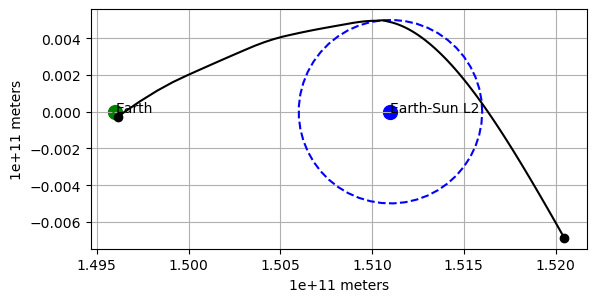

In [10]:
#pydrake.systems.pyplot_visualizer().animate
earth_traj = []
l2_traj = []

for t in range(time_steps+1):
    earth_traj.append(universe.planet_orbit_rel_pos("Earth",t*time_interval))
    l2_traj.append(universe.planet_orbit_rel_pos("Earth-Sun L2", t*time_interval))
earth_traj = np.array(earth_traj)
l2_traj = np.array(l2_traj)

#state_opt[:,:2] = state_opt[:,:2] + earth_traj

def create_animation(state_opt, universe):
    def animate(n):
        for lnum,line in enumerate(lines):
            if lnum == 0:
                line.set_data(state_opt[:n, 0], state_opt[:n, 1])
            elif lnum == 1:
                line.set_data(earth_traj[:n, 0], earth_traj[:n, 1])
            elif lnum == 2:
                line.set_data(l2_traj[:n, 0], l2_traj[:n, 1])
        return lines
    fig, ax = plot_state_trajectory(state_opt, universe)
    #fig = plt.figure()
    #ax = plt.axes(xlim=(-1.5,1.5), ylim=(0,1))
    plotlays, plotcols = [3], ["orange","red","green"]
    lines = []
    for index in range(1):
        lobj = ax.plot([],[],lw=2,color=plotcols[index])[0]
        lines.append(lobj)

    # uncomment below to create animation

    #anim = FuncAnimation(fig, animate, frames=state_opt.shape[0], interval=200)
    #anim.save("test.gif");
    #Image(open('test.gif','rb').read())

create_animation(append_free_evoln(state_opt, 50), universe)
#plt.figure()
#plot_rocket_limits(satellite, thrust_opt, state_opt[:-2])

# Direct collocation

In [11]:
from pydrake.symbolic import Variable, MakeVectorVariable
from pydrake.systems.primitives import SymbolicVectorSystem
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    DirectCollocation,
    FiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    LogVectorOutput,
    MakeFiniteHorizonLinearQuadraticRegulator,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PlanarSceneGraphVisualizer,
    SceneGraph,
    Simulator,
    SnoptSolver,
    Solve,
    TrajectorySource,
    LeafSystem_,
    LeafSystem,
    TemplateSystem
)

#x, y, vx, vy, u = Variable("x"), Variable("y"), Variable("vx"), Variable("vy"), MakeVectorVariable(2, "u")
#jwst_system = SymbolicVectorSystem(state=[x, y, vx, vy], dynamics=universe.rocket_continuous_dynamics(np.array([x,y,vx,vy]), u), input=[u], output=[x, y, vx, vy])
# Define the system.
@TemplateSystem.define("RocketPlant_")
def RocketPlant_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            state_index = self.DeclareContinuousState(4)  # One state variable.
            self.DeclareStateOutputPort("y", state_index)  # One output: y=x.
            self.DeclareVectorInputPort("u", 2)

        def DoCalcTimeDerivatives(self, context, derivatives):
            q = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            qdot = universe.rocket_continuous_dynamics(q, u)
            derivatives.get_mutable_vector().SetFromVector(qdot)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)
    return Impl

# Instantiate the System
RocketPlant = RocketPlant_[None]

def jwst_dircol(initial_state = None, final_state = None, halo_orbit = False, num_days = 30, dt=1/365, lagrange_pt = "Earth-Sun L2"):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(RocketPlant())
    scene_graph = builder.AddSystem(SceneGraph())
    #GliderGeometry.AddToBuilder(builder, glider.GetOutputPort("state"), scene_graph)
    #visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    #meshcat.Delete()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    N = int(num_days/365/dt)
    dircol = DirectCollocation(
        rocket,
        rocket.CreateDefaultContext(),
        num_time_samples=N,
        minimum_time_step=dt,
        maximum_time_step=dt,
    )
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    u = dircol.input()
    
    #dircol.AddConstraintToAllKnotPoints(-satellite.thrust_limit <= np.sqrt(u[0]**2 + u[1]**2))
    #dircol.AddConstraintToAllKnotPoints(np.sqrt(u[0]**2 + u[1]**2) <= satellite.thrust_limit)
    #dircol.AddConstraintToAllKnotPoints(-satellite.velocity_limit <= np.sqrt(vx**2 + vy**2))
    #dircol.AddConstraintToAllKnotPoints(np.sqrt(vx**2 + vy**2) <= satellite.thrust_limit)

    rocket_initial_pos = np.array([universe.get_planet("Earth").position[0], universe.get_planet("Earth").position[1] - universe.get_planet("Earth").orbit])
    rocket_initial_vel = np.array([unit_converter["length"](10e3)/unit_converter["time"](1), 0])
    initial_state = initial_state if initial_state is not None else np.array([rocket_initial_pos[0], rocket_initial_pos[1], rocket_initial_vel[0], rocket_initial_vel[1]])
    #prog.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())
    for residual in universe.constraint_state_to_orbit(dircol.initial_state(), dircol.input(0), "Earth"):
        prog.AddConstraint(residual == 0)

    rocket_final_pos = np.array([universe.get_planet(lagrange_pt).position[0] - universe.get_planet(lagrange_pt).orbit, universe.get_planet(lagrange_pt).position[1]])
    rocket_final_vel = np.array([0,halo_vel])
    final_state = np.array([rocket_final_pos[0], rocket_final_pos[1], rocket_final_vel[0], rocket_final_vel[1]]) if final_state is None else final_state #not halo_orbit else np.concatenate([2*universe.get_planet(lagrange_pt).position - initial_state[:2], -initial_state[2:]])

    if not halo_orbit:
        for residual in universe.constraint_state_to_orbit(dircol.final_state(), dircol.input(N-1), lagrange_pt, fixed_orbit=True):
            prog.AddConstraint(residual == 0)
            prog.AddConstraint(dircol.final_state()[2]**2 + dircol.final_state()[3]**2 == halo_vel**2)  
        #prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
    else:
        z = dircol.state()[:2]
        rel_pos = z - universe.get_planet(lagrange_pt).position
        dircol.AddConstraintToAllKnotPoints(z.dot(z) <= 2*universe.get_planet(lagrange_pt).orbit**2)
        prog.AddBoundingBoxConstraint(0.9*final_state, 1.1*final_state, dircol.final_state())

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * (u[0]**2 + u[1]**2))
    #prog.AddQuadraticErrorCost(
     #       np.diag([1, 1, 1, 1]), final_state, dircol.final_state()
      #  )


    if not halo_orbit:
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
            [0.0, N*dt], np.column_stack([initial_state, final_state])
        )
        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
    else:    
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([i*dt for i in range(N)], np.column_stack(circle_traj(initial_state, num_knots=N)))
        initial_u_trajectory = PiecewisePolynomial.FirstOrderHold([i*dt for i in range(N)], np.column_stack([np.array([0.,0.]) for i in range(N)]))
        dircol.SetInitialTrajectory(initial_u_trajectory, initial_x_trajectory)

    result = Solve(prog)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    u_trajectory = dircol.ReconstructInputTrajectory(result)

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), 100
            )
        ]
    )
    u_knots = np.hstack(
        [
            u_trajectory.value(t)
            for t in np.linspace(
                u_trajectory.start_time(), u_trajectory.end_time(), 100
            )
        ]
    )
    #fig, ax = plt.subplots()
    #ax.set_xlabel("$q$")
    #ax.set_ylabel("$\dot{q}$")
    #ax.plot(x_knots[0, :], x_knots[1, :])
    #display(plt.show())
    return x_knots, x_trajectory, u_knots, u_trajectory
x_knots, x_traj, u_knots, u_traj = jwst_dircol(num_days=30, lagrange_pt="Earth-Sun L2")
fig, ax = plot_state_trajectory(x_knots.T, universe)

AssertionError: 

# Analyzing fuel consumption for different initial/final conditions

In [ ]:
lagrange_pt="Earth-Sun L2"

rocket_initial_pos = np.array([universe.get_planet("Earth").position[0], universe.get_planet("Earth").position[1] - universe.get_planet("Earth").orbit])
rocket_initial_vel = np.array([unit_converter["length"](10e3)/unit_converter["time"](1), 0])
rocket_initial_state = np.concatenate([rocket_initial_pos, rocket_initial_vel])
rocket_final_pos = np.array([universe.get_planet(lagrange_pt).position[0] - universe.get_planet(lagrange_pt).orbit, universe.get_planet(lagrange_pt).position[1]])
rocket_final_vel = np.array([0,halo_vel])
rocket_final_state = np.concatenate([rocket_final_pos, rocket_final_vel])

init_list = circle_traj(rocket_initial_state, vector_offset=universe.get_planet("Earth").position, R=universe.get_planet("Earth").orbit, num_knots=10)
final_list = circle_traj(rocket_final_state, vector_offset=universe.get_planet(lagrange_pt).position, R=universe.get_planet(lagrange_pt).orbit, num_knots=10)
res = np.zeros((len(init_list), len(final_list)))
dt = 1/365

for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        x_knots, x_traj, u_knots, u_traj = jwst_dircol(initial_state = init_list[i], final_state = final_list[j], num_days=30, dt=dt, lagrange_pt=lagrange_pt)
        fuel = fuel_consumption(u_knots, dt)
        res[i,j] = fuel
        print(i, j)
#fig, ax = plot_state_trajectory(x_knots.T, universe)
#new_knots = append_free_evoln(x_knots.T, 1000)
#fig, ax = plot_state_trajectory(new_knots, universe)
#create_animation(new_knots, universe)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


Text(0, 0.5, 'Final position')

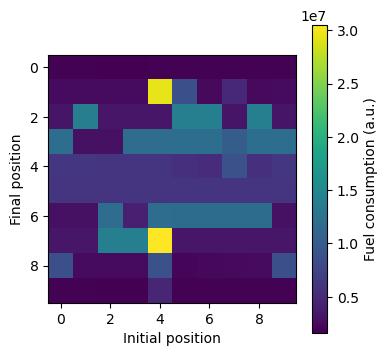

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(res)
plt.colorbar(label="Fuel consumption (a.u.)")
plt.xlabel("Initial position")
plt.ylabel("Final position")

Text(0, 0.5, '1e+11 meters')

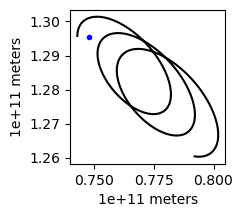

In [ ]:
#x_knots2, x_traj2, u_traj2 = jwst_dircol(initial_state=x_knots[:,-1], halo_orbit=True, num_days=200)
#fig, ax = plot_state_trajectory(x_knots2.T, universe)

# Trajectory stabilization using finite horizon LQR

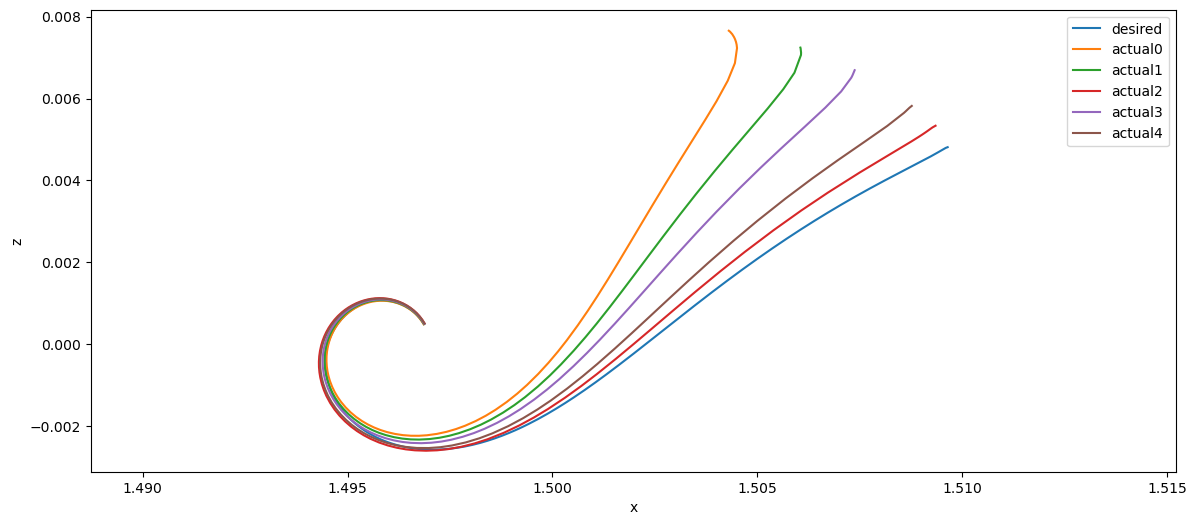

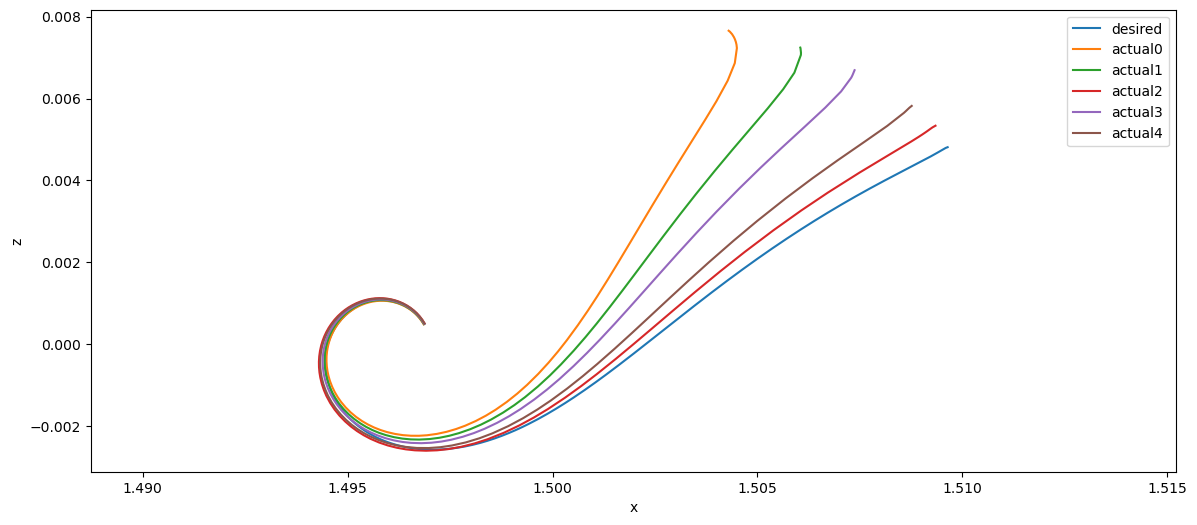

In [ ]:
def finite_horizon_lqr(x_traj, u_traj):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(RocketPlant())
    scene_graph = builder.AddSystem(SceneGraph())
    logger = LogVectorOutput(rocket.GetOutputPort("y"), builder)

    Q = np.diag([10, 10, 1, 1])
    R = np.array([[1,0],[0,1]])
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.Qf = np.diag(
        [
            (1 / 0.05) ** 2,
            (1 / 0.05) ** 2,
            1,
            1
        ]
    )
    # options.use_square_root_method = True  # Pending drake PR #16812
    options.x0 = x_traj
    options.u0 = u_traj

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            system=rocket,
            context=rocket.CreateDefaultContext(),
            t0=x_traj.start_time(),
            tf=x_traj.end_time(),
            Q=Q,
            R=R,
            options=options,
        )
    )
    builder.Connect(controller.get_output_port(), rocket.get_input_port())
    builder.Connect(rocket.GetOutputPort("y"), controller.get_input_port())

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    rocket_context = rocket.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = x_traj.vector_values(ts)

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(desired_state[0], desired_state[1], label="desired")
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.axis("equal")

    rng = np.random.default_rng(123)
    out = []
    for i in range(5):
        context.SetTime(x_traj.start_time())
        initial_state = x_traj.value(x_traj.start_time())
        initial_state += 1e-5 * rng.standard_normal()
        rocket_context.SetContinuousState(initial_state[:])

        simulator.Initialize()
        simulator.AdvanceTo(x_traj.end_time())

        log = logger.FindLog(context)
        state = log.data()
        out.append(state)
        log.Clear()
        ax.plot(state[0], state[1], label=f"actual{i}")
        #ax.plot(universe.get_planet("Earth").position[0], universe.get_planet("Earth").position[1], "g.")
        #ax.plot(universe.get_planet("Earth-Sun L2").position[0], universe.get_planet("Earth-Sun L2").position[1], "b.")

    ax.legend()
    #return desired_state, out

    desired_traj, actual_traj = finite_horizon_lqr(x_traj, u_traj)

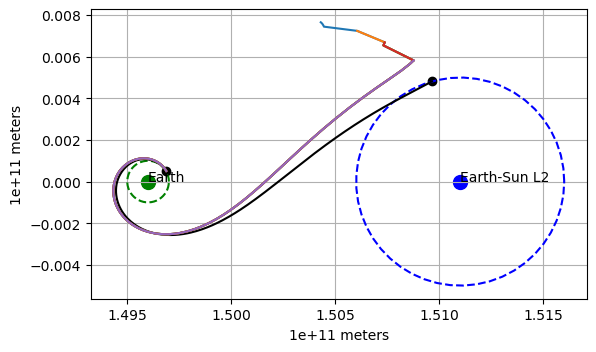

In [ ]:
fig = plt.figure()
ax = plt.axes()
plot_state_trajectory(desired_traj.T, universe, fig, ax)
for traj in actual_traj:
    ax.plot(traj[0], traj[1])

# Miscellaneous

In [ ]:
plt.figure(figsize=(2,2))
for i in range(len(init_list)):
    #plt.plot(init_list[i][0], init_list[i][1], "r.")
    plt.scatter([final_list[i][0]], [final_list[i][1]], color="k")
    plt.text(1.0003*final_list[i][0], 1.0003*final_list[i][1], f"{i}")
    #ax.scatter(*planet.position, s=100, c=planet.color)
#plt.xlabel("1e+11 meters")
#plt.ylabel("1e+11 meters")
plt.axis("off")

# MPC controller (work in progress)

In [ ]:
class MpcController(VectorSystem):

    def __init__(self, quadrotor_plant, init_state, target_state, time_horizon, 
                max_time_samples, thrust_limit, obstacle_list, initial_thrust, time_step):

        # define this system as having 12 inputs and 4 outputs
        VectorSystem.__init__(self, 4, 2)
        self.quadrotor_plant = quadrotor_plant
        self.init_state = init_state
        self.target_state = target_state
        self.time_horizon = time_horizon
        self.max_time_samples = max_time_samples
        self.thrust_limit = thrust_limit
        self.obstacle_list = obstacle_list
        self.current_step = 0

        self.current_output = inital_thrust
        
        self.time_step = time_step

        # initialize optimization
        self.prog = MathematicalProgram()
        
    def DoCalcVectorOutput(self, context, inp, state, output):
        # quadrotor_mutable_context = self.quadrotor_plant.GetMyMutableContextFromRoot(self.sim_context)
        quadrotor_context = self.quadrotor_plant.CreateDefaultContext()

        # fix input port of quadrotor with output of MPC controller, in order to perform linearization
        # this is the output from the previous iteration of the sim
        self.quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, self.current_output)

        # input into the controller is the state of the quadrotor
        # set the context equal to the current state
        quadrotor_context.SetContinuousState(inp)
        current_state = inp

        num_samples = self.time_horizon

        # optimization variables
        # input to controller is state, x
        self.x = self.prog.NewContinuousVariables(self.time_horizon + 1, 12, 'state')
        # output from controller is thrust, u
        self.u = self.prog.NewContinuousVariables(self.time_horizon, 4, 'thrust')

        ## Add starting state constraint based on current state
        self.prog.AddBoundingBoxConstraint(current_state, current_state, self.x[0,:])

        for t in range(num_samples):
            
            # calculate residual using Implicit Euler integration
            residuals = self.quadrotor_discrete_dynamics(A, B, self.x[t], 
            self.x[t+1], self.u[t], self.time_step)
            for residual in residuals:
                self.prog.AddLinearConstraint(residual == 0)

            # calculate quadratic state error cost
            # error  = self.x[t] - self.target_state
            # self.prog.AddCost(error.T.dot(Q.dot(error)) )
            self.prog.AddQuadraticErrorCost(Q, self.target_state, self.x[t])

            self.prog.AddCost(self.u[t].dot(R.dot(self.u[t])))


        #### Define initial guess trajectory by linearly interpolating between current state and target 
        initial_x_trajectory = self.generate_initial_guess(current_state, self.target_state, 
            num_samples, self.time_step )

        self.prog.SetInitialGuess(self.x, initial_x_trajectory)


        # print("running solver")
        result = Solve(self.prog)
        assert (result.is_success())

        # # retrieve optimal solution
        u_trajectory = result.GetSolution(self.u)
        # x_trajectory = result.GetSolution(x)
        

        #### set output to first step of thrust trajectory ###
        print(u_trajectory[0])
        output[:] = u_trajectory[0]

        # output[:] = [10.,10.,10.,10.]
        self.current_output = output
        print(output)

        ##### increment current timestep
        self.current_step += 1

NameError: name 'new_knots' is not defined

<Figure size 200x200 with 0 Axes>

# Controllability/Stabilizability (work in progress)

In [17]:
from numpy import linalg as LA
def Vxx(state):
    x,y = state[0], state[1]
    xe = x - universe.get_planet("Earth").position[0]
    ye = y - universe.get_planet("Earth").position[1]
    xs = x - universe.get_planet("Sun").position[0]
    ys = y - universe.get_planet("Sun").position[1]
    re = np.sqrt(xe**2 + ye**2)
    rs = np.sqrt(xs**2 + ys**2)
    return universe.G * (universe.get_planet("Earth").mass / re**3 * (1 - 3*xe**2/re**2) \
            + universe.get_planet("Sun").mass / rs**3 * (1 - 3*xs**2/rs**2)) - universe.omega_E**2
def Vxy(state):
    x,y = state[0], state[1]
    xe = x - universe.get_planet("Earth").position[0]
    ye = y - universe.get_planet("Earth").position[1]
    xs = x - universe.get_planet("Sun").position[0]
    ys = y - universe.get_planet("Sun").position[1]
    re = np.sqrt(xe**2 + ye**2)
    rs = np.sqrt(xs**2 + ys**2)
    return -3*universe.G * (universe.get_planet("Earth").mass*xe*ye / re**5  \
            + universe.get_planet("Sun").mass*xs*ys / rs**5)
def Vyy(state):
    x,y = state[0], state[1]
    xe = x - universe.get_planet("Earth").position[0]
    ye = y - universe.get_planet("Earth").position[1]
    xs = x - universe.get_planet("Sun").position[0]
    ys = y - universe.get_planet("Sun").position[1]
    re = np.sqrt(xe**2 + ye**2)
    rs = np.sqrt(xs**2 + ys**2)
    return universe.G * (universe.get_planet("Earth").mass / re**3 * (1 - 3*ye**2/re**2) \
            + universe.get_planet("Sun").mass / rs**3 * (1 - 3*ys**2/rs**2)) - universe.omega_E**2

def A(state):
    return np.array([[0,0,1,0],[0,0,0,1],[-Vxx(state),-Vxy(state),0,2*universe.omega_E],[-Vxy(state),-Vyy(state),-2*universe.omega_E,0]])
def B(state):
    return np.array([[0,0],[0,0],[1,0],[0,1]])
for state in state_opt:
    evals, evecs = LA.eig(A(state))
    print("evals", evals)
    print("beta", evecs.dot(B(state)))

evals [-5.26671448e+03   +0.j          6.82121026e-13+3724.12963717j
  6.82121026e-13-3724.12963717j  5.26671448e+03   +0.j        ]
beta [[ 2.33274949e-19+0.00023468j  9.20054516e-05+0.j        ]
 [ 3.40610301e-07+0.00013048j -1.66091107e-04+0.j        ]
 [ 8.73993243e-01+0.j          4.84566444e-01+0.j        ]
 [ 4.85936344e-01-0.00126848j -8.74754437e-01+0.j        ]]
evals [ 5.00972583e+02  +0.j        -5.00972583e+02  +0.j
  2.13162821e-14+354.2924227j  2.13162821e-14-354.2924227j]
beta [[ 3.55977124e-05-0.00108011j  3.55977124e-05+0.00108011j]
 [-1.31977599e-18+0.00260743j -1.31977599e-18-0.00260743j]
 [ 3.82673911e-01+0.012612j    3.82673911e-01-0.012612j  ]
 [-9.23793077e-01+0.j         -9.23793077e-01+0.j        ]]
evals [ 2.12796571e+02  +0.j         -2.12796571e+02  +0.j
  1.40998324e-14+150.58066835j  1.40998324e-14-150.58066835j]
beta [[ 2.03280297e-04-0.00296083j  2.03280297e-04+0.00296083j]
 [ 3.33460185e-18+0.00594075j  3.33460185e-18-0.00594075j]
 [ 4.45843357e-01+0.0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d729b92b-de26-45ed-8760-a4a4a4d4151f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>